In [38]:
from keras.layers import Embedding
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [39]:
from keras.datasets import imdb
from keras import preprocessing

In [40]:
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [1]:
x_train

NameError: name 'x_train' is not defined

In [42]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 142us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 2s 94us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
20000/20000 [==============================] - 2s 90us/step - loss: 0.4263 - acc: 0.8077 - val_loss: 0.5008 - val_acc: 0.7452
Epoch 5/10
20000/20000 [==============================] - 2s 103us/step - loss: 0.3930 - acc: 0.8258 - val_loss: 0.4981 - val_acc: 0.7538
Epoch 6/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.3668 - acc: 0.8395 - val_loss: 0.5014 - val_acc: 0.7530
Epoch 7/10
20000/20000 [==============================] - 2s 88us/step - loss: 0.3435 - acc: 0.8533 - val_loss: 0.5052 - val_ac

In [45]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 39us/step


[0.5214696465301514, 0.75584]

# From raw text to word embeddings

In [46]:
import os
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f= open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

25000

In [47]:
len(texts)

25000

In [48]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [76]:
maxlen = 100  # We will cut reviews after 100 words
training_samples = 10000  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

In [77]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [78]:
len(sequences)

25000

In [79]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 87393 unique tokens.


In [80]:
data = pad_sequences(sequences, maxlen=maxlen)

In [81]:
data

array([[   9,  115,   22, ...,   32,  522,    8],
       [6871,   45,   85, ...,  181,  445,  154],
       [1605,  140, 5832, ...,    8,    1,  179],
       ...,
       [   4, 1017,    2, ...,   35,  310,   43],
       [   4,    1,  168, ...,   26, 1219, 6074],
       [   5, 4895,   41, ...,   55,  107, 4274]], dtype=int32)

In [82]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [83]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [84]:
x_train.shape

(10000, 100)

In [85]:
# ! wget http://nlp.stanford.edu/data/glove.6B.zip

In [86]:
# ! unzip glove.6B.zip

In [87]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [88]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [89]:
embedding_matrix.shape

(10000, 100)

In [90]:
embedding_matrix[2]

array([-0.071953  ,  0.23127   ,  0.023731  , -0.50638002,  0.33923   ,
        0.19589999, -0.32943001,  0.18364   , -0.18057001,  0.28963   ,
        0.20448001, -0.54960001,  0.27399001,  0.58327001,  0.20468   ,
       -0.49228001,  0.19973999, -0.070237  , -0.88049001,  0.29484999,
        0.14071   , -0.1009    ,  0.99449003,  0.36973   ,  0.44554001,
        0.28997999, -0.1376    , -0.56365001, -0.029365  , -0.4122    ,
       -0.25268999,  0.63181001, -0.44767001,  0.24363001, -0.10813   ,
        0.25163999,  0.46967   ,  0.37549999, -0.23613   , -0.14128999,
       -0.44536999, -0.65736997, -0.042421  , -0.28636   , -0.28810999,
        0.063766  ,  0.20281   , -0.53542   ,  0.41306999, -0.59722   ,
       -0.38613999,  0.19389001, -0.17809001,  1.66180003, -0.011819  ,
       -2.3736999 ,  0.058427  , -0.26980001,  1.2823    ,  0.81924999,
       -0.22322001,  0.72931999, -0.053211  ,  0.43507001,  0.85010999,
       -0.42934999,  0.92663997,  0.39050999,  1.05850005, -0.24

# Define a Model

In [91]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [93]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 3s 332us/step - loss: 0.7016 - acc: 0.5850 - val_loss: 0.6114 - val_acc: 0.6690
Epoch 2/10
10000/10000 [==============================] - 1s 136us/step - loss: 0.5714 - acc: 0.7053 - val_loss: 0.6171 - val_acc: 0.6581
Epoch 3/10
10000/10000 [==============================] - 1s 143us/step - loss: 0.4880 - acc: 0.7735 - val_loss: 0.6027 - val_acc: 0.6848
Epoch 4/10
10000/10000 [==============================] - 1s 117us/step - loss: 0.4438 - acc: 0.7977 - val_loss: 0.5967 - val_acc: 0.7088
Epoch 5/10
10000/10000 [==============================] - 1s 116us/step - loss: 0.3766 - acc: 0.8338 - val_loss: 0.5969 - val_acc: 0.7061
Epoch 6/10
10000/10000 [==============================] - 1s 116us/step - loss: 0.3283 - acc: 0.8624 - val_loss: 0.7399 - val_acc: 0.6722
Epoch 7/10
10000/10000 [==============================] - 1s 133us/step - loss: 0.2881 - acc: 0.8790 - val_loss: 0.7337 - 

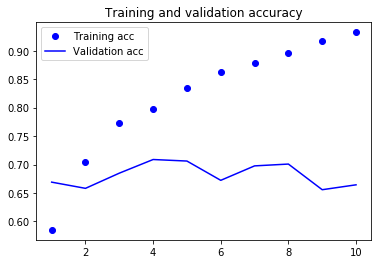

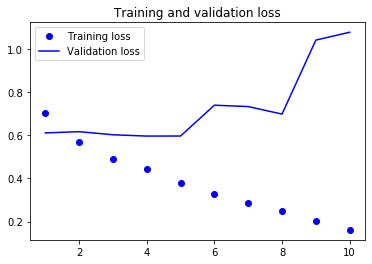

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Without pretrain Embedding

In [95]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 3s 330us/step - loss: 0.5066 - acc: 0.7335 - val_loss: 0.3547 - val_acc: 0.8425
Epoch 2/10
10000/10000 [==============================] - 1s 140us/step - lo

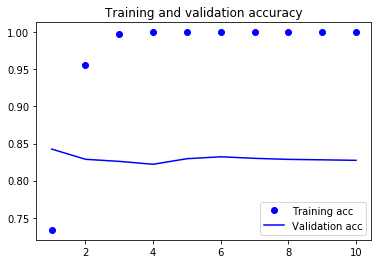

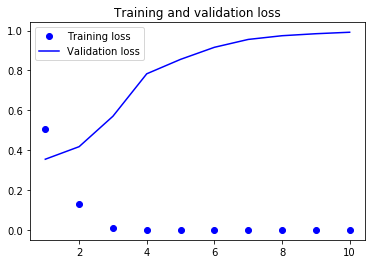

In [96]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [97]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [98]:
print(texts[0])
print(sequences[0])

Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.
[282, 171, 443, 6416, 45, 3585, 41, 3, 15, 17, 222, 1109, 72, 1803, 1171, 36, 1, 1353, 1366, 2127, 

In [99]:
len(tokenizer.word_index)

87393

In [100]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 36us/step


[0.7694405340397358, 0.73692]